__File: operator_evolution_fig.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     January 7, 2020__

This notebook creates figures for _Operator evolution from the similarity renormalization group and the Magnus expansion_. Each function creates and saves a figure to the __Figures/Operator_evolution__ folder or returns value(s) for a calculation. Below is an outline of each function:
* potential_contours - Plots contours of an SRG-evolving potential in $\lambda$.
* potential_slices - Plots the diagonal or far off-diagonal matrix elements of an SRG-evolving potential in $\lambda$.
* potential_slices_high_cutoffs - Same as above function but specific to high cutoff non-local LO potentials from Wendt 2011 (kvnn = 900-902).

__Revision history:<br/>__
* January 7, 2020 - Created by combining several Jupyter notebooks: srg_potentials_fig.ipynb, srg_observables_fig.ipynb, srg_operators_fig.ipynb, and magnus_fig.ipynb.

In [1]:
from os import chdir, getcwd
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.linalg import expm
# Scripts made by A.T.
from Figures import figures_functions as ff
from Potentials.vsrg_macos import load_save_potentials as lp
from SRG_codes.srg_unitary_transformation import SRG_unitary_transformation
import observables as ob
import operators as op

__Variables and constants__

In [2]:
# Number of points in momentum-mesh
ntot = 120

# NN potentials for phase shift plots and NN potential contours - (kvnn, kmax, kmid, ntot)
em_n3lo = (10, 30.0, 4.0, ntot) # EM N3LO (500 MeV) potential
rke_n4lo = (111, 8.0, 2.0, ntot) # RKE N4LO (450 MeV) potential
gez_n2lo = (222, 10.0, 2.0, ntot) # Gezerlis et al. N2LO (1 fm) potential
wendt_4 = (900, 30.0, 4.0, ntot) # Wendt LO (4 fm^-1) potential
wendt_9 = (901, 30.0, 4.0, ntot) # Wendt LO (9 fm^-1) potential
wendt_20 = (902, 30.0, 4.0, ntot) # Wendt LO (20 fm^-1) potential

# SRG generators and lambda values for momentum distribution plots - (generator, lambda, lambda_bd)
wegner_1_5 = ('Wegner', 1.5)
block_diag_2 = ('Block-diag', 1.5, 2.00)
block_diag_3 = ('Block-diag', 1.5, 3.00)

# Continuum state energy for momentum distribution plots
eps = 200.0

# lambda values for potential contours
lambda_array_contours = np.array([np.inf, 3.0, 2.0, 1.5])
# lambda values for potential slices
lambda_array_slices = np.array([np.inf, 3.0, 1.5, 1.0])
# lambda values for high cutoff potentials
lambda_array_high_cutoffs = np.array([10.0, 2.8, 2.0, 1.2])

__Plotting functions__

In [3]:
def phase_shifts(channel, *potentials):
    """
    Plots phase shifts [deg] of NN potentials with respect to relative momentum [fm^-1]. This is a 1 x 1 plot.
    
    Parameters
    ----------
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    *potentials : tuple
        Specifications for phase shifts of an NN potential in the format (kvnn, kmax, kmid, ntot) where kvnn (int) 
        is the number specifying the potential, kmax (float) is the maximum value in the momentum mesh [fm^-1], kmid
        (float) is the mid-point value in the mesh [fm^-1], and ntot (int) is the number of points in the mesh. For 
        example, (10, 30.0, 4.0, 120) corresponds to the Entem-Machleidt N3LO potential.

    Saves
    -----
    file_name : phase_shifts_ with an extension based off the given arguments. For example,
                phase_shifts_3S1_kvnns_10_106_222.pdf.
    
    """
    
    
    # Check that at least one potential was provided
    if not potentials: 
        print('At least one potential must be specified.')
        return None
    
    
    # --- Set-up --- #
    
    # h-bar^2 / M [MeV fm^2]
    hbar_sq_over_M = 41.47    

    # Coupled-channel?
    coupled_channel = lp.coupled_channel(channel) # This is a boolean variable
    
    # Relative momentum in fm^-1
    k_max = 4.0
    M = 200 # Number of points in array
    k_points = np.linspace(0.01, k_max, M)
    # We could also plot phase shifts with respect to E_lab but we choose k for comparison to potential matrix 
    # elements in momentum space
    # Conversion to E_lab
    e_array = 2.0 * hbar_sq_over_M * k_points**2
    
    # Figure size for 1 x 1 figure
    width = 4
    height = 4
    figure_size = (width, height) # This gives a square figure
    
    # x-axis limits
    xlim = [0.0, k_max]
     
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\delta$' + ' [deg]'
    y_label_size = 20
    legend_label_size = 14
    channel_label = ff.channel_label_conversion(channel)
    channel_label_size = 22
    axes_tick_size = 14
    
    # Things which depend on the channel: y-axis limits and some label locations
    if channel == '1S0':
        ylim = [-80.0, 70.0]
        legend_label_location = 'lower left'
        channel_label_location = 'upper right'
    elif channel == '3S1':
        ylim = [-40.0, 180.0]
        legend_label_location = 'upper right'
        channel_label_location = 'lower left'
    elif channel == '1P1':
        ylim = [-60.0, 10.0]
        legend_label_location = 'lower left'
        channel_label_location = 'upper center'
    else:
        ylim = [-40.0, 180.0]
        legend_label_location = 'lower left'
        channel_label_location = 'upper right'
    
    # File name of figure
    file_name = 'phase_shifts_%s_' % channel + 'kvnns'
    
    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot lines --- #
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size) 
    
    # Loop over specifications keeping track of the curve number i
    i = 0 # Curve number
    for potential in potentials:
        
        # Set kvnn, kmax, and kmid
        kvnn = potential[0]
        kmax = potential[1]
        kmid = potential[2]
        ntot = potential[3]
        
        # Update name of the file (based off kvnn)
        file_name += '_' + str(kvnn)
        
        # Load momentum, weights, and potential
        k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot)
    
        # Calculate phase shifts
        # If coupled-channel, use the Stapp convention
        if coupled_channel:
            phase_shifts_array = ob.coupled_channel_phase_shifts(e_array, V_matrix, k_array, k_weights,
                                                                 convention='Stapp')
            # Plot only delta_a_array (excludes delta_b and epsilon)
            delta_array = phase_shifts_array[:, 0]
        else:
            delta_array = ob.phase_shifts(e_array, V_matrix, k_array, k_weights)
        
        # Curve labels and styles
        curve_color = ff.xkcd_colors(i) # Color
        curve_style = ff.line_styles(i) # Linestyle
        curve_label = ff.kvnn_label_conversion(kvnn) # Legend label
        
        # Add to figure
        ax.plot(k_points, delta_array, color=curve_color, linestyle=curve_style, label=curve_label)
        
        i += 1
        
        
    # --- Set figure specifications and save --- #

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    # Add legend
    ax.legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add channel as anchored text
    anchored_text = AnchoredText(channel_label, prop=dict(size=channel_label_size), loc=channel_label_location,
                                 frameon=False)
    ax.add_artist(anchored_text)
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    # Show plot in notebook
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [4]:
def deuteron_momentum_distribution(kvnn, kmax, kmid, ntot, *generators):
    """
    Plots the deuteron momentum distribution [fm^3] with respect to momentum [fm^-1] for the initial distribution
    and different SRG-evolved distributions. This is a 1 x 1 semi-log plot.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    *generators : tuple
        Specifications for SRG-evolution in the format (generator, lambda, lambda_bd) where generator (str) is the
        SRG generator, lambda (float) is evolution parameter [fm^-1], and lambda_bd (float, opt) is the 
        block-diagonal cutoff [fm^-1].

    Saves
    -----
    file_name : deuteron_momentum_distribution_ with an extension based off the given arguments. For example,
                deuteron_momentum_distribution_kvnn10_Wegner_1,5_Block-diag_2,00_Block-diag_3,00.pdf.
    
    """
    
    
    # Check that at least one generator was provided
    if not generators: 
        print('At least one generator must be specified.')
        return None
    

    # --- Set-up --- #
    
    # Channel is 3S1 for deuteron
    channel = '3S1'
    # Deuteron energy in MeV
    eps = -2.22
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot) 
    
    # Compute initial wave function
    psi_initial = ob.wave_function(H_initial, eps)
    u_initial = psi_initial[:ntot] # 3S1 component
    w_initial = psi_initial[ntot:] # 3D1 component
    
    # Initial momentum distribution (divide by momenta and weights for mesh-independent result)
    phi_squared_initial = ( u_initial**2 + w_initial**2 ) / ( k_array**2 * k_weights )
    
    # Figure size for 1 x 1 figure
    width = 4
    height = 4
    figure_size = (width, height) # This gives a square figure
    
    # Limits of x and y axes
    xlim = [0.0, 4.0]
    ylim = [1e-5, 1e3]
    
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\phi_d^2$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 20
    legend_label_size = 14
    lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_inf_label =r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
    lambda_label_size = 14
    axes_tick_size = 14

    # Location of labels
    legend_label_location = 'upper right'
    lambda_label_location = 'lower left'
    
    # File name of figure
    file_name = 'deuteron_momentum_distribution_kvnn%d_' % kvnn 
    
    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot lines --- #
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size) # This gives a square figure
    
    # Loop over generators keeping track of the curve number i
    i = 0 # Curve number
    for g in generators:
        
        generator = g[0] # SRG generator
        lamb = g[1] # lambda value
        if generator == 'Block-diag':
            lambda_bd = g[2] # Lambda_BD for block-diagonal evolution
            # Update name of the file (based off generator)
            file_name += '_' + generator + '_%.2f' % lambda_bd
        else:
            # Wegner evolution - set lambda_bd to 0
            lambda_bd = 0.0
            # Update name of the file (based off generator)
            file_name += '_' + generator + '_%.1f' % lamb
            
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb, lambda_bd)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Compute evolved wave function
        psi_evolved = ob.wave_function(H_initial, eps, U=U_matrix)
        u_evolved = psi_evolved[:ntot] # 3S1 component
        w_evolved = psi_evolved[ntot:] # 3D1 component
        
        # Evolved momentum distribution (divide by momenta and weights for mesh-independent result)
        phi_squared_evolved = ( u_evolved**2 + w_evolved**2 ) / ( k_array**2 * k_weights )
        
        # Curve labels and styles
        curve_color = ff.xkcd_colors(i+1) # Color starting at red (initial momentum distribution will be black)
        curve_style = ff.line_styles(i) # Linestyle
        curve_label = ff.generator_label_conversion(generator, lambda_bd) # Legend label
        
        # Add to figure
        ax.semilogy(k_array, phi_squared_evolved, color=curve_color, linestyle=curve_style, label=curve_label)
        
        i += 1
        
    # Plot initial momentum distribution last to prevent it from being covered up
    curve_color = ff.xkcd_colors(0) # Initial momentum distribution is black
    curve_style = ff.line_styles(i) # Linestyle
    curve_label = lambda_inf_label # Legend label
    
    # Add to figure
    ax.semilogy(k_array, phi_squared_initial, color=curve_color, linestyle=curve_style, label=curve_label)

    
    # --- Set figure specifications and save --- #
    
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    # Add legend
    ax.legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    anchored_text = AnchoredText(lambda_label % lamb, prop=dict(size=lambda_label_size), loc=lambda_label_location,
                                 frameon=False)
    ax.add_artist(anchored_text)
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    # Show plot in notebook
    plt.show()

    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [5]:
def continuum_state_momentum_distribution(eps, kvnn, channel, kmax, kmid, ntot, *generators):
    """
    Plots a continuum state momentum distribution [fm^3] with respect to momentum [fm^-1] for the initial 
    distribution and different SRG-evolved distributions. This is a 1 x 1 semi-log plot.
    
    Parameters
    ----------
    eps : float
        Eigen-energy of the continuum state [MeV].
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    *generators : tuple
        Specifications for SRG-evolution in the format (generator, lambda, lambda_bd) where generator (str) is the
        SRG generator, lambda (float) is evolution parameter [fm^-1], and lambda_bd (float, opt) is the 
        block-diagonal cutoff [fm^-1].

    Saves
    -----
    file_name : continuum_state_momentum_distribution_ with an extension based off the given arguments. For example,
                continuum_state_momentum_distribution_kvnn10_Wegner_1,5_Block-diag_2,00_Block-diag_3,00.pdf.
    
    """
    
    
    # Check that at least one generator was provided
    if not generators: 
        print('At least one generator must be specified.')
        return None
    

    # --- Set-up --- #
    
    # Coupled-channel?
    coupled_channel = lp.coupled_channel(channel) # This is a boolean variable
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot) 
    
    # Compute initial wave function
    psi_initial = ob.wave_function(H_initial, eps)
    
    # Coupled-channel
    if coupled_channel:
        
        u_initial = psi_initial[:ntot] # 3S1 component
        w_initial = psi_initial[ntot:] # 3D1 component
        
        # Initial momentum distribution (divide by momenta and weights for mesh-independent result)
        phi_squared_initial = ( u_initial**2 + w_initial**2 ) / ( k_array**2 * k_weights )
        
    else:
        
        phi_squared_initial = psi_initial**2 / ( k_array**2 * k_weights )
        
    # Figure size for 1 x 1 figure
    width = 4
    height = 4
    figure_size = (width, height) # This gives a square figure
    
    # Limits of x and y axes
    xlim = [0.0, 5.0]
    ylim = [1e-6, 1e2]
    
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\phi_{\epsilon}^2$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 20
    legend_label_size = 10
    lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_inf_label =r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
    lambda_label_size = 14
    axes_tick_size = 14
    
    # Location of labels
    lambda_label_location = 'upper left'
    
    # Things which depend on value of epsilon: location of labels
    if eps > 200:
        legend_label_location = 'center left'
    else:
        legend_label_location = 'upper right'
    
    # File name of figure
    file_name = 'continuum_state_momentum_distribution_eps%.1f_kvnn%d_%s' % (eps, kvnn, channel)
    
    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot lines --- #
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size) # This gives a square figure
    
    # Loop over generators keeping track of the curve number i
    i = 0 # Curve number
    for g in generators:
        
        generator = g[0] # SRG generator
        lamb = g[1] # lambda value
        if generator == 'Block-diag':
            lambda_bd = g[2] # Lambda_BD for block-diagonal evolution
            # Update name of the file (based off generator)
            file_name += '_' + generator + '_%.2f' % lambda_bd
        else:
            # Wegner evolution - set lambda_bd to 0
            lambda_bd = 0.0
            # Update name of the file (based off generator)
            file_name += '_' + generator + '_%.1f' % lamb
            
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb, lambda_bd)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Compute evolved wave function
        psi_evolved = ob.wave_function(H_initial, eps, U=U_matrix)
        
        # Coupled-channel
        if coupled_channel:
        
            u_evolved = psi_evolved[:ntot] # 3S1 component
            w_evolved = psi_evolved[ntot:] # 3D1 component
            
            # Evolved momentum distribution (divide by momenta and weights for mesh-independent result)
            phi_squared_evolved = ( u_evolved**2 + w_evolved**2 ) / ( k_array**2 * k_weights )
            
        else:
            
            phi_squared_evolved = psi_evolved**2 / ( k_array**2 * k_weights )
            
        # Curve labels and styles
        curve_color = ff.xkcd_colors(i+1) # Color starting at red (initial momentum distribution will be black)
        curve_style = ff.line_styles(i) # Linestyle
        curve_label = ff.generator_label_conversion(generator, lambda_bd) # Legend label
        
        # Add to figure
        ax.semilogy(k_array, phi_squared_evolved, color=curve_color, linestyle=curve_style, label=curve_label)
        
        i += 1
        
    # Plot initial momentum distribution last to prevent it from being covered up
    curve_color = ff.xkcd_colors(0) # Initial momentum distribution is black
    curve_style = ff.line_styles(i) # Linestyle
    curve_label = lambda_inf_label # Legend label
    
    # Add to figure
    ax.semilogy(k_array, phi_squared_initial, color=curve_color, linestyle=curve_style, label=curve_label)

    
    # --- Set figure specifications and save --- #
    
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    # Add legend
    ax.legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    anchored_text = AnchoredText(lambda_label % lamb, prop=dict(size=lambda_label_size), loc=lambda_label_location,
                                 frameon=False)
    ax.add_artist(anchored_text)
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    # Show plot in notebook
    plt.show()

    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [6]:
def potential_contours(channel, generator, lambda_array, *potentials):
    """
    Plots SRG-evolved NN potential contours [fm] with respect to momentum [fm^-1]. This is an 3 x 4 contour plot.
    
    Parameters
    ----------
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling. Make sure there are 5 values in this array. Note, np.inf is an option for an unevolved
        potential.
    *potentials : tuple
        Specifications for an NN potential in the format (kvnn, kmax, kmid, ntot) where kvnn (int) is the number 
        specifying the potential, kmax (float) is the maximum value in the momentum mesh [fm^-1], kmid (float) is 
        the mid-point value in the mesh [fm^-1], and ntot (int) is the number of points in the mesh. For example, 
        (111, 8.0, 2.0, 120) corresponds to the RKE N4LO (450 MeV) potential.

    Saves
    -----
    file_name : potential_contours_channel_kvnns_ with an extension based off the given arguments. For example,
                potential_contours_3S1_kvnns_10_111_222_Wegner.pdf.
    
    """
    
    
    # Check that at least one potential was provided
    if not potentials: 
        print('At least one potential must be specified.')
        return None
    
    
    # --- Set-up --- #
    
    # Size of figure
    row_number = 3
    col_number = 4
    figure_size = (4*col_number, 3.5*row_number) # (width, height) - extra width for colorbar
    
    # Limits of x and y axes
    axes_max = 4.0
    
    # Specifications of axes
    # Step-size in labeling tick marks
    axes_stepsize = 1.0
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    
    # Labels and fontsize
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    potential_label_size = 17
    # Label the block-diagonal Lambda
    if generator == 'Block-diag':
        lambda_label = r'$\Lambda=%.1f$' + ' fm' + r'$^{-1}$'
        lambda_inf_label = r'$\Lambda=\infty$' + ' fm' + r'$^{-1}$'
    # For band-diagonal generators, label lambda
    else:
        lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
        lambda_inf_label = r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
    lambda_label_size = 17
    colorbar_label = '[fm]'
    colorbar_label_size = 20
    axes_tick_size = 18
    colorbar_tick_size = 18
    
    # Location of labels
    lambda_label_location = 'lower left'
    potential_label_location = 'upper right'
    
    # Color scheme for contour plots
    color_style = 'jet'
    
    # Things which depend on the channel: limits of colorbar
    if channel in ['1S0', '3S1']:
        mx = 1.0
        mn = -1.0
    elif channel in ['1P1']:
        mx = 0.4
        mn = -0.4
    else:
        mx = 1.0
        mn = -1.0
    
    # File name of figure
    file_name = 'potential_contours_%s_kvnns' % channel

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data --- #
    
    # Initialize dictionary to store evolved potentials and momentum arrays
    d = {}
    
    # Loop over specifications
    for potential in potentials:
        
        # Set kvnn, kmax, and kmid
        kvnn = potential[0]
        kmax = potential[1]
        kmid = potential[2]
        ntot = potential[3]
        
        # Update name of the file (based off kvnn)
        file_name += '_' + str(kvnn)
        
        d[kvnn] = {} # Store momentum and potential in here
        
        # Load momentum
        k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Load initial potential if lambda = infinity
            if lamb == np.inf:
                V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot)
            # Load evolved potential
            else:
                if generator == 'Block-diag':
                    # For block-diagonal, set lambda = 1 fm^-1
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, 
                                                 np.array([1.0]), lambda_bd=lamb)
                else:
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                
            # Interpolate the potential through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, V_matrix_int = ff.interpolate_matrix(k_array, V_matrix, axes_max)
            
            # Save to dictionary
            d[kvnn]['k_array'] = k_array_int
            d[kvnn][lamb] = V_matrix_int
            
            
    # --- Plot contours --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    
    # Row 1 #
    kvnn_1 = potentials[0][0]
    potential_label_1 = ff.kvnn_label_conversion(kvnn_1, full_label=False)
    
    # Sub-plot 1
    axs[0, 0].pcolormesh(d[kvnn_1]['k_array'], d[kvnn_1]['k_array'], d[kvnn_1][lambda_array[0]], cmap=color_style, 
                         vmin=mn, vmax=mx, rasterized=True)
    # Specify axes limits
    axs[0, 0].set_xlim( (0, axes_max) )
    axs[0, 0].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 0].xaxis.set_ticks(axes_ticks)
    axs[0, 0].xaxis.set_ticklabels(axes_ticks)
    axs[0, 0].yaxis.set_ticks(axes_ticks)
    axs[0, 0].yaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 0].xaxis.set_label_position('top')
    axs[0, 0].xaxis.tick_top()
    axs[0, 0].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_1 = axs[0, 0].xaxis.get_major_ticks()
    xticks_1[-1].set_visible(False)
    # Prevent overlapping y-axis tick marks
    yticks_1 = axs[0, 0].yaxis.get_major_ticks()
    yticks_1[-1].set_visible(False)
    # Set axes labels
    axs[0, 0].set_xlabel(x_label, fontsize=axes_label_size)
    axs[0, 0].set_ylabel(y_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_1 = AnchoredText(lambda_inf_label, prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 0].add_artist(lambda_anchored_text_1)
    
    # Sub-plot 2
    axs[0, 1].pcolormesh(d[kvnn_1]['k_array'], d[kvnn_1]['k_array'], d[kvnn_1][lambda_array[1]], cmap=color_style, 
                         vmin=mn, vmax=mx, rasterized=True)
    # Specify axes limits
    axs[0, 1].set_xlim( (0, axes_max) )
    axs[0, 1].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 1].xaxis.set_ticks(axes_ticks)
    axs[0, 1].xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 1].xaxis.set_label_position('top')
    axs[0, 1].xaxis.tick_top()
    axs[0, 1].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_2 = axs[0, 1].xaxis.get_major_ticks()
    xticks_2[-1].set_visible(False)
    # Set axes labels
    axs[0, 1].set_xlabel(x_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_2 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 1].add_artist(lambda_anchored_text_2)
    
    # Sub-plot 3
    axs[0, 2].pcolormesh(d[kvnn_1]['k_array'], d[kvnn_1]['k_array'], d[kvnn_1][lambda_array[2]], cmap=color_style, 
                         vmin=mn, vmax=mx, rasterized=True)
    # Specify axes limits
    axs[0, 2].set_xlim( (0, axes_max) )
    axs[0, 2].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 2].xaxis.set_ticks(axes_ticks)
    axs[0, 2].xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 2].xaxis.set_label_position('top')
    axs[0, 2].xaxis.tick_top()
    axs[0, 2].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_3 = axs[0, 2].xaxis.get_major_ticks()
    xticks_3[-1].set_visible(False)
    # Set axes labels
    axs[0, 2].set_xlabel(x_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_3 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 2].add_artist(lambda_anchored_text_3)
    
    # Sub-plot 4
    axs[0, 3].pcolormesh(d[kvnn_1]['k_array'], d[kvnn_1]['k_array'], d[kvnn_1][lambda_array[3]], cmap=color_style, 
                         vmin=mn, vmax=mx, rasterized=True)
    # Specify axes limits
    axs[0, 3].set_xlim( (0, axes_max) )
    axs[0, 3].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 3].xaxis.set_ticks(axes_ticks)
    axs[0, 3].xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 3].xaxis.set_label_position('top')
    axs[0, 3].xaxis.tick_top()
    axs[0, 3].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Set axes labels
    axs[0, 3].set_xlabel(x_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_4 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 3].add_artist(lambda_anchored_text_4)
    # Add potential label as anchored text
    potential_anchored_text_1 = AnchoredText(potential_label_1, prop=dict(size=potential_label_size),
                                             loc=potential_label_location)
    axs[0, 3].add_artist(potential_anchored_text_1)
    
    
    # Row 2 #
    kvnn_2 = potentials[1][0]
    potential_label_2 = ff.kvnn_label_conversion(kvnn_2, full_label=False)
    
    # Sub-plot 5
    axs[1, 0].pcolormesh(d[kvnn_2]['k_array'], d[kvnn_2]['k_array'], d[kvnn_2][lambda_array[0]], cmap=color_style, 
                         vmin=mn, vmax=mx, rasterized=True)
    # Specify axes limits
    axs[1, 0].set_xlim( (0, axes_max) )
    axs[1, 0].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[1, 0].yaxis.set_ticks(axes_ticks)
    axs[1, 0].yaxis.set_ticklabels(axes_ticks)
    axs[1, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping y-axis tick marks
    yticks_2 = axs[1, 0].yaxis.get_major_ticks()
    yticks_2[-1].set_visible(False)
    # Set axes labels
    axs[1, 0].set_ylabel(y_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_5 = AnchoredText(lambda_inf_label, prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 0].add_artist(lambda_anchored_text_5)
        
    # Sub-plot 6
    axs[1, 1].pcolormesh(d[kvnn_2]['k_array'], d[kvnn_2]['k_array'], d[kvnn_2][lambda_array[1]], cmap=color_style, 
                         vmin=mn, vmax=mx, rasterized=True)
    # Specify axes limits
    axs[1, 1].set_xlim( (0, axes_max) )
    axs[1, 1].set_ylim( (0, axes_max) )
    # Add lambda label as anchored text
    lambda_anchored_text_6 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 1].add_artist(lambda_anchored_text_6)
    
    # Sub-plot 7
    axs[1, 2].pcolormesh(d[kvnn_2]['k_array'], d[kvnn_2]['k_array'], d[kvnn_2][lambda_array[2]], cmap=color_style, 
                         vmin=mn, vmax=mx, rasterized=True)
    # Specify axes limits
    axs[1, 2].set_xlim( (0, axes_max) )
    axs[1, 2].set_ylim( (0, axes_max) )
    # Add lambda label as anchored text
    lambda_anchored_text_7 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 2].add_artist(lambda_anchored_text_7)
    
    # Sub-plot 8
    axs[1, 3].pcolormesh(d[kvnn_2]['k_array'], d[kvnn_2]['k_array'], d[kvnn_2][lambda_array[3]], cmap=color_style, 
                         vmin=mn, vmax=mx, rasterized=True)
    # Specify axes limits
    axs[1, 3].set_xlim( (0, axes_max) )
    axs[1, 3].set_ylim( (0, axes_max) )
    # Add lambda label as anchored text
    lambda_anchored_text_8 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 3].add_artist(lambda_anchored_text_8)
    # Add potential label as anchored text
    potential_anchored_text_2 = AnchoredText(potential_label_2, prop=dict(size=potential_label_size),
                                             loc=potential_label_location)
    axs[1, 3].add_artist(potential_anchored_text_2)
    
    
    # Row 3 #
    kvnn_3 = potentials[2][0]
    potential_label_3 = ff.kvnn_label_conversion(kvnn_3, full_label=False)
    
    # Sub-plot 9
    axs[2, 0].pcolormesh(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[0]], cmap=color_style, 
                         vmin=mn, vmax=mx, rasterized=True)
    # Specify axes limits
    axs[2, 0].set_xlim( (0, axes_max) )
    axs[2, 0].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[2, 0].yaxis.set_ticks(axes_ticks)
    axs[2, 0].yaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[2, 0].xaxis.tick_top()
    axs[2, 0].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Set axes labels
    axs[2, 0].set_ylabel(y_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_9 = AnchoredText(lambda_inf_label, prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[2, 0].add_artist(lambda_anchored_text_9)
    
    # Sub-plot 10
    axs[2, 1].pcolormesh(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[1]], cmap=color_style, 
                         vmin=mn, vmax=mx, rasterized=True)
    # Specify axes limits
    axs[2, 1].set_xlim( (0, axes_max) )
    axs[2, 1].set_ylim( (0, axes_max) )
    # Position of x-axis label and tick marks
    axs[2, 1].xaxis.tick_top()
    axs[2, 1].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Add lambda label as anchored text
    lambda_anchored_text_10 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                           loc=lambda_label_location)
    axs[2, 1].add_artist(lambda_anchored_text_10)
    
    # Sub-plot 11
    axs[2, 2].pcolormesh(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[2]], cmap=color_style, 
                         vmin=mn, vmax=mx, rasterized=True)
    # Specify axes limits
    axs[2, 2].set_xlim( (0, axes_max) )
    axs[2, 2].set_ylim( (0, axes_max) )
    # Position of x-axis label and tick marks
    axs[2, 2].xaxis.tick_top()
    axs[2, 2].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Add lambda label as anchored text
    lambda_anchored_text_11 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                           loc=lambda_label_location)
    axs[2, 2].add_artist(lambda_anchored_text_11)
    
    # Sub-plot 12
    c = axs[2, 3].pcolormesh(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[3]], 
                             cmap=color_style, vmin=mn, vmax=mx, rasterized=True)
    # Specify axes limits
    axs[2, 3].set_xlim( (0, axes_max) )
    axs[2, 3].set_ylim( (0, axes_max) )
    # Position of x-axis label and tick marks
    axs[2, 3].xaxis.tick_top()
    axs[2, 3].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Add lambda label as anchored text
    lambda_anchored_text_12 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                           loc=lambda_label_location)
    axs[2, 3].add_artist(lambda_anchored_text_12)
    # Add potential label as anchored text
    potential_anchored_text_3 = AnchoredText(potential_label_3, prop=dict(size=potential_label_size),
                                             loc=potential_label_location)
    axs[2, 3].add_artist(potential_anchored_text_3)

    
    # --- Set figure specifications and save --- #
    
    # Invert y-axis
    plt.gca().invert_yaxis()
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Adjust for colorbar space
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
    # Add colorbar and set tick size
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)
    # Show plot in notebook
    plt.show()

    # Add generator to file name
    file_name += '_%s' % generator
    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [7]:
def potential_contours_generators(kvnn, channel, kmax, kmid, ntot, lambda_array):
    """
    Plots SRG-evolved NN potential contours [fm] with respect to momentum [fm^-1]. This is an 2 x 4 contour plot.
    Analogous to potential_contours function but compares SRG band- and block-diagonal decoupling fixing the NN
    potential.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling. Make sure there are 5 values in this array. Note, np.inf is an option for an unevolved
        potential.

    Saves
    -----
    file_name : potential_contours_generators_channel_kvnn_ with an extension based off the given arguments. For 
                example, potential_contours_generators_3S1_kvnn_111.pdf.
    
    """
    
    
    # --- Set-up --- #
    
    # SRG generators
    generators = ['Wegner', 'Block-diag']
    
    # Size of figure
    row_number = 2
    col_number = 4
    figure_size = (4*col_number, 3.5*row_number) # (width, height) - extra width for colorbar
    
    # Limits of x and y axes
    axes_max = 4.0
    
    # Specifications of x and y axes
    # Step-size in labeling tick marks
    axes_stepsize = 1.0
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    
    # Labels and fontsize
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    generator_label_size = 17
    # Label the block-diagonal Lambda
    Lambda_label = r'$\Lambda=%.1f$' + ' fm' + r'$^{-1}$'
    Lambda_inf_label = r'$\Lambda=\infty$' + ' fm' + r'$^{-1}$'
    # For band-diagonal generators, label lambda
    lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_inf_label = r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
    lambda_label_size = 17
    colorbar_label = '[fm]'
    colorbar_label_size = 20
    axes_tick_size = 18
    colorbar_tick_size = 18
    
    # Location of labels
    lambda_label_location = 'lower left'
    generator_label_location = 'upper right'
    
    # Color scheme for contour plots
    color_style = 'jet'
    
    # Things which depend on the channel: limits of colorbar
    if channel in ['1S0', '3S1']:
        mx = 1.0
        mn = -1.0
    elif channel in ['1P1']:
        mx = 0.4
        mn = -0.4
    else:
        mx = 1.0
        mn = -1.0
    
    # File name of figure
    file_name = 'potential_contours_generators_%s_kvnn_%d' % (channel, kvnn)

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Load momentum
    k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    
    # Loop over generators
    for generator in generators:
        
        d[generator] = {}
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Load initial potential if lambda = infinity
            if lamb == np.inf:
                V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot)
            # Load evolved potential
            else:
                if generator == 'Block-diag':
                    # For block-diagonal, set lambda = 1 fm^-1
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, 
                                                 np.array([1.0]), lambda_bd=lamb)
                else:
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                
            # Interpolate the potential through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, V_matrix_int = ff.interpolate_matrix(k_array, V_matrix, axes_max)
            
            # Save to dictionary
            d[generator][lamb] = V_matrix_int
            
            
    # --- Plot contours --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    
    # Row 1 #
    generator_label_1 = ff.generator_label_conversion(generators[0])
    
    # Sub-plot 1
    axs[0, 0].pcolormesh(k_array_int, k_array_int, d[generators[0]][lambda_array[0]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[0, 0].set_xlim( (0, axes_max) )
    axs[0, 0].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 0].xaxis.set_ticks(axes_ticks)
    axs[0, 0].xaxis.set_ticklabels(axes_ticks)
    axs[0, 0].yaxis.set_ticks(axes_ticks)
    axs[0, 0].yaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 0].xaxis.set_label_position('top')
    axs[0, 0].xaxis.tick_top()
    axs[0, 0].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axistick marks
    xticks_1 = axs[0, 0].xaxis.get_major_ticks()
    xticks_1[-1].set_visible(False)
    # Prevent overlapping y-axis tick marks
    yticks_1 = axs[0, 0].yaxis.get_major_ticks()
    yticks_1[-1].set_visible(False)
    # Set axes labels
    axs[0, 0].set_xlabel(x_label, fontsize=axes_label_size)
    axs[0, 0].set_ylabel(y_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_1 = AnchoredText(lambda_inf_label, prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 0].add_artist(lambda_anchored_text_1)
    
    # Sub-plot 2
    axs[0, 1].pcolormesh(k_array_int, k_array_int, d[generators[0]][lambda_array[1]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[0, 1].set_xlim( (0, axes_max) )
    axs[0, 1].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 1].xaxis.set_ticks(axes_ticks)
    axs[0, 1].xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 1].xaxis.set_label_position('top')
    axs[0, 1].xaxis.tick_top()
    axs[0, 1].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_2 = axs[0, 1].xaxis.get_major_ticks()
    xticks_2[-1].set_visible(False)
    # Set axes labels
    axs[0, 1].set_xlabel(x_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_2 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 1].add_artist(lambda_anchored_text_2)
    
    # Sub-plot 3
    axs[0, 2].pcolormesh(k_array_int, k_array_int, d[generators[0]][lambda_array[2]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[0, 2].set_xlim( (0, axes_max) )
    axs[0, 2].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 2].xaxis.set_ticks(axes_ticks)
    axs[0, 2].xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 2].xaxis.set_label_position('top')
    axs[0, 2].xaxis.tick_top()
    axs[0, 2].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_3 = axs[0, 2].xaxis.get_major_ticks()
    xticks_3[-1].set_visible(False)
    # Set axes labels
    axs[0, 2].set_xlabel(x_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_3 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 2].add_artist(lambda_anchored_text_3)
    
    # Sub-plot 4
    axs[0, 3].pcolormesh(k_array_int, k_array_int, d[generators[0]][lambda_array[3]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[0, 3].set_xlim( (0, axes_max) )
    axs[0, 3].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 3].xaxis.set_ticks(axes_ticks)
    axs[0, 3].xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 3].xaxis.set_label_position('top')
    axs[0, 3].xaxis.tick_top()
    axs[0, 3].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Set axes labels
    axs[0, 3].set_xlabel(x_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_4 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 3].add_artist(lambda_anchored_text_4)
    # Add potential label as anchored text
    generator_anchored_text_1 = AnchoredText(generator_label_1, prop=dict(size=generator_label_size),
                                             loc=generator_label_location)
    axs[0, 3].add_artist(generator_anchored_text_1)
    
    
    # Row 2 #
    generator_label_2 = ff.generator_label_conversion(generators[1])
    
    # Sub-plot 5
    axs[1, 0].pcolormesh(k_array_int, k_array_int, d[generators[1]][lambda_array[0]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[1, 0].set_xlim( (0, axes_max) )
    axs[1, 0].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[1, 0].yaxis.set_ticks(axes_ticks)
    axs[1, 0].yaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[1, 0].xaxis.tick_top()
    axs[1, 0].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Set axes labels
    axs[1, 0].set_ylabel(y_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_5 = AnchoredText(Lambda_inf_label, prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 0].add_artist(lambda_anchored_text_5)
    
    # Sub-plot 6
    axs[1, 1].pcolormesh(k_array_int, k_array_int, d[generators[1]][lambda_array[1]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[1, 1].set_xlim( (0, axes_max) )
    axs[1, 1].set_ylim( (0, axes_max) )
    # Position of x-axis label and tick marks
    axs[1, 1].xaxis.tick_top()
    axs[1, 1].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Add lambda label as anchored text
    lambda_anchored_text_6 = AnchoredText(Lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 1].add_artist(lambda_anchored_text_6)
    
    # Sub-plot 7
    axs[1, 2].pcolormesh(k_array_int, k_array_int, d[generators[1]][lambda_array[2]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[1, 2].set_xlim( (0, axes_max) )
    axs[1, 2].set_ylim( (0, axes_max) )
    # Position of x-axis label and tick marks
    axs[1, 2].xaxis.tick_top()
    axs[1, 2].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Add lambda label as anchored text
    lambda_anchored_text_7 = AnchoredText(Lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 2].add_artist(lambda_anchored_text_7)
    
    # Sub-plot 8
    c = axs[1, 3].pcolormesh(k_array_int, k_array_int, d[generators[1]][lambda_array[3]], cmap=color_style, vmin=mn, 
                             vmax=mx, rasterized=True)
    # Specify axes limits
    axs[1, 3].set_xlim( (0, axes_max) )
    axs[1, 3].set_ylim( (0, axes_max) )
    # Position of x-axis label and tick marks
    axs[1, 3].xaxis.tick_top()
    axs[1, 3].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Add lambda label as anchored text
    lambda_anchored_text_8 = AnchoredText(Lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 3].add_artist(lambda_anchored_text_8)
    # Add potential label as anchored text
    generator_anchored_text_2 = AnchoredText(generator_label_2, prop=dict(size=generator_label_size),
                                             loc=generator_label_location)
    axs[1, 3].add_artist(generator_anchored_text_2)

    
    # --- Set figure specifications and save --- #
    
    # Invert y-axis
    plt.gca().invert_yaxis()
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Adjust for colorbar space
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
    # Add colorbar and set tick size
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)
    # Show plot in notebook
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [8]:
def potential_slices(channel, lambda_array, *potentials):
    """
    Plots SRG-evolved NN potentials [fm] with respect to momentum [fm^-1] isolating the diagonal and far 
    off-diagonal matrix elements. This is an 2 x 4 plot.
    
    Parameters
    ----------
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    *potentials : tuple
        Specifications for an NN potential in the format (kvnn, kmax, kmid, ntot) where kvnn (int) is the number 
        specifying the potential, kmax (float) is the maximum value in the momentum mesh [fm^-1], kmid (float) is 
        the mid-point value in the mesh [fm^-1], and ntot (int) is the number of points in the mesh. For example, 
        (111, 8.0, 2.0, 120) corresponds to the RKE N4LO (450 MeV) potential.

    Saves
    -----
    file_name : potential_slices_3S1_kvnns_ with an extension based off the given arguments. For example,
                potential_slices_3S1_kvnns_10_111_222.pdf.
    
    """
    
    
    # Check that at least one potential was provided
    if not potentials: 
        print('At least one SRG-evolved potential must be specified.')
        return None

    
    # --- Set-up --- #
    
    # Store kvnn values in this list
    kvnns = []
    # SRG generators
    generators = ['Wegner', 'Block-diag']
    
    # Size of figure
    row_number = 2
    col_number = 4
    figure_size = (4*col_number, 4*row_number) # (width, height)
    
    # Limits of x axis
    xlim = [0.0, 3.0]
        
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label_diag = 'V(k,k) [fm]'
    y_label_size = 20
    wegner_label = ff.generator_label_conversion('Wegner')
    block_diag_label = ff.generator_label_conversion('Block-diag')
    legend_label_size = 17
    # Add channel label for diagonal element plot only
    channel_label = ff.channel_label_conversion(channel)
    channel_label_size = 22
    lambda_inf_label = r'$\lambda$' + ', ' + r'$\Lambda=\infty$' + ' fm' + r'$^{-1}$'
    lambda_label = r'$\lambda$' + ', ' + r'$\Lambda=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_label_size = 17
    axes_tick_size = 16
    
    # Location of labels
    legend_label_location = 'lower right'
    channel_label_location = 'lower right'
    lambda_label_location = 'upper left'
    
    # Line colors and styles
    kvnn_1_color = 'xkcd:black'
    kvnn_2_color = 'xkcd:red'
    kvnn_3_color = 'xkcd:blue'
    generator_1_style = 'solid'
    generator_2_style = 'dashed'
    
    # Things which depend on the channel: limits and stepsize of y-axis, and y-axis label
    if channel == '1S0':
        ylim = [-3.5, 2.0]
        y_stepsize = 1
        # Set off-diagonal k = 0 fm^-1 for other channels
        y_label_off_diag = 'V(k,0) [fm]'
    elif channel == '3S1':
        ylim = [-4.5, 2.0]
        y_stepsize = 1
        # Set off-diagonal k = 0 fm^-1 for other channels
        y_label_off_diag = 'V(k,0) [fm]'
    elif channel == '1P1':
        ylim = [-0.5, 0.8]
        y_stepsize = 0.25
        # Set off-diagonal k = 0.5 fm^-1 for 1P1 channel
        y_label_off_diag = 'V(k,0.5) [fm]'
        
    # Specifications of axes
    # Step-size in labeling tick marks
    x_stepsize = 0.5
    # x and y axes ticks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)

    # File name of figure
    file_name = 'potential_slices_%s_kvnns' % channel # This reads 'potential_slices_channel_kvnns'

    # Current working directory
    cwd = getcwd()


    # --- Load data --- #
    
    # Initialize dictionary to store evolved potentials and momentum arrays
    d = {}
    
    # Loop over specifications
    for potential in potentials:
        
        # Set kvnn, kmax, and kmid
        kvnn = potential[0]
        kmax = potential[1]
        kmid = potential[2]
        ntot = potential[3]
        
        # Append to kvnn list
        kvnns.append(kvnn)
        
        # Update name of the file (based off kvnn)
        file_name += '_' + str(kvnn)
        
        d[kvnn] = {} # Store momentum and potential in here
        
        # Load momentum
        k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        d[kvnn]['k_array'] = k_array
        
        # Loop over SRG generators
        for generator in generators:
            
            d[kvnn][generator] = {}
            
            # Loop over lambda values
            for lamb in lambda_array:
            
                d[kvnn][generator][lamb] = {} # Split into cases on diagonals and far off-diagonals
            
                # Load initial potential if lambda = infinity
                if lamb == np.inf:
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot)
                # Load evolved potential
                else:
                    if generator == 'Block-diag':
                        # For block-diagonal, set lambda = 1 fm^-1
                        V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, 
                                                     np.array(lambda_array[-1]), lambda_bd=lamb)
                            
                    else:
                        V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                
                # Save to dictionary
                d[kvnn][generator][lamb]['diag'] = np.diag( V_matrix )[:ntot]
                if channel == '1P1': # For 1P1 channel, select a slice where k does not equal zero
                    k = 0.5
                    k_index = op.find_q_index(k, k_array) # k_array[k_index] ~ 0.5 fm^-1 (closest value to 0.5)
                    d[kvnn][generator][lamb]['off-diag'] = V_matrix[:ntot, k_index]
                else:
                    d[kvnn][generator][lamb]['off-diag'] = V_matrix[:ntot, 0]

            
    # --- Plot --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Labels for potentials
    potential_label_1 = ff.kvnn_label_conversion(kvnns[0], full_label=False)
    potential_label_2 = ff.kvnn_label_conversion(kvnns[1], full_label=False)
    potential_label_3 = ff.kvnn_label_conversion(kvnns[2], full_label=False)
    
    # Row 1 #
    # Diagonal matrix elements
    
    # Sub-plot 1
    axs[0, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[0]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style, label=potential_label_1)
    axs[0, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[0]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style, label=potential_label_2)
    axs[0, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[0]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style, label=potential_label_3)
    axs[0, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 0].set_xlim(xlim)
    axs[0, 0].set_ylim(ylim)
    axs[0, 0].yaxis.set_ticks(y_ticks)
    axs[0, 0].yaxis.set_ticklabels(y_ticks)
    axs[0, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping y-axis tick marks
    yticks_1 = axs[0, 0].yaxis.get_major_ticks()
    yticks_1[0].set_visible(False)
    # Set axes labels
    axs[0, 0].set_ylabel(y_label_diag, fontsize=y_label_size)
    # Set legend label
    axs[0, 0].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_1 = AnchoredText(lambda_inf_label, prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 0].add_artist(lambda_anchored_text_1)
    
    # Sub-plot 2
    axs[0, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[1]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[1]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[1]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 1].set_xlim(xlim)
    axs[0, 1].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_2 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 1].add_artist(lambda_anchored_text_2)
    
    # Sub-plot 3
    axs[0, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[2]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[2]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[2]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 2].set_xlim(xlim)
    axs[0, 2].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_3 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 2].add_artist(lambda_anchored_text_3)
    
    # Sub-plot 4
    axs[0, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[3]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[3]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[3]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 3].set_xlim(xlim)
    axs[0, 3].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_4 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 3].add_artist(lambda_anchored_text_4)
    
    
    # Row 2 #
    # Far off-diagonal matrix elements
    
    # Sub-plot 5
    axs[1, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[0]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style, label=wegner_label)
    axs[1, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[0]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[0]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style, label=block_diag_label)
    axs[1, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 0].set_xlim(xlim)
    axs[1, 0].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 0].xaxis.set_ticks(x_ticks)
    axs[1, 0].xaxis.set_ticklabels(x_ticks)
    axs[1, 0].yaxis.set_ticks(y_ticks)
    axs[1, 0].yaxis.set_ticklabels(y_ticks)
    axs[1, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_5 = axs[1, 0].xaxis.get_major_ticks()
    xticks_5[-1].set_visible(False)
    # Set axes labels
    axs[1, 0].set_xlabel(x_label, fontsize=x_label_size)
    axs[1, 0].set_ylabel(y_label_off_diag, fontsize=y_label_size)
    # Set legend label
    axs[1, 0].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_5 = AnchoredText(lambda_inf_label, prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 0].add_artist(lambda_anchored_text_5)
    
    # Sub-plot 6
    axs[1, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[1]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[1]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[1]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 1].set_xlim(xlim)
    axs[1, 1].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 1].xaxis.set_ticks(x_ticks)
    axs[1, 1].xaxis.set_ticklabels(x_ticks)
    axs[1, 1].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_6 = axs[1, 1].xaxis.get_major_ticks()
    xticks_6[-1].set_visible(False)
    # Set axes labels
    axs[1, 1].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_6 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 1].add_artist(lambda_anchored_text_6)
    
    # Sub-plot 7
    axs[1, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[2]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[2]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[2]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 2].set_xlim(xlim)
    axs[1, 2].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 2].xaxis.set_ticks(x_ticks)
    axs[1, 2].xaxis.set_ticklabels(x_ticks)
    axs[1, 2].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_7 = axs[1, 2].xaxis.get_major_ticks()
    xticks_7[-1].set_visible(False)
    # Set axes labels
    axs[1, 2].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_7 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 2].add_artist(lambda_anchored_text_7)
                   
    # Sub-plot 8
    axs[1, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[3]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[3]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[3]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 3].set_xlim(xlim)
    axs[1, 3].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 3].xaxis.set_ticks(x_ticks)
    axs[1, 3].xaxis.set_ticklabels(x_ticks)
    axs[1, 3].tick_params(labelsize=axes_tick_size)
    # Set axes labels
    axs[1, 3].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_8 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 3].add_artist(lambda_anchored_text_8)
    # Add channel label as anchored text
    channel_anchored_text = AnchoredText(channel_label, prop=dict(size=channel_label_size),
                                         loc=channel_label_location, frameon=False)
    axs[1, 3].add_artist(channel_anchored_text)
    

    # --- Set figure specifications and save --- #

    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Show plot in notebook
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [9]:
def potential_slices_high_cutoffs(lambda_array):
    """
    Plots SRG-evolved NN potentials [fm] with respect to momentum [fm^-1] isolating the diagonal and far 
    off-diagonal matrix elements. This is an 2 x 4 plot. This function is analogous to potential_slices but specific
    to high cutoff potentials in the 3S1 channel.
    
    Parameters
    ----------
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.

    Saves
    -----
    file_name : potential_slices_high_cutoffs_kvnns_ with an extension based off the given arguments. For 
                example, potential_slices_high_cutoffs_kvnns_900_901_902.pdf.
    
    """

    
    # --- Set-up --- #
    
    # Specifications of high cutoff potentials
    kvnns = [900, 901, 902]
    channel = '3S1' # Partial wave channel
    kmax = 30.0 # Max momentum value in mesh
    kmid = 4.0 # Mid-point in mesh
    ntot = 120 # Number of points in mesh
    # SRG generators
    generators = ['Wegner', 'Block-diag']
    
    # Size of figure
    row_number = 2
    col_number = 4
    figure_size = (4*col_number, 4*row_number) # (width, height)
    
    # Limits of x and y axes
    xlim = [0.0, 3.0]
    ylim = [-4.0, 4.5]
    
    # Specifications of axes
    # Step-size in labeling tick marks
    x_stepsize = 0.5
    y_stepsize = 1
    # x and y axes ticks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
        
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label_diag = 'V(k,k) [fm]'
    y_label_off_diag = 'V(k,0) [fm]'
    y_label_size = 20
    wegner_label = ff.generator_label_conversion('Wegner')
    block_diag_label = ff.generator_label_conversion('Block-diag')
    legend_label_size = 17
    lambda_label = r'$\lambda$' + ', ' + r'$\Lambda=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_label_size = 17
    axes_tick_size = 16
    
    # Location of labels
    legend_label_location = 'upper right'
    lambda_label_location = 'upper left'
    
    # Line colors and styles
    kvnn_1_color = 'xkcd:black'
    kvnn_2_color = 'xkcd:red'
    kvnn_3_color = 'xkcd:blue'
    generator_1_style = 'solid'
    generator_2_style = 'dashed'
        
    # File name of figure
    file_name = 'potential_slices_high_cutoffs_kvnns_%s_%s_%s' % (kvnns[0], kvnns[1], kvnns[2])

    # Current working directory
    cwd = getcwd()


    # --- Load data --- #
    
    # Initialize dictionary to store evolved potentials and momentum arrays
    d = {}
    
    # Loop over specifications
    for kvnn in kvnns:
        
        d[kvnn] = {} # Store momentum and potential in here

        # Load momentum
        k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        d[kvnn]['k_array'] = k_array
        
        # Loop over SRG generators
        for generator in generators:
            
            d[kvnn][generator] = {}
            
            # Loop over lambda values
            for lamb in lambda_array:
            
                d[kvnn][generator][lamb] = {} # Split into cases on diagonals and far off-diagonals
            
                # Load evolved potential
                if generator == 'Block-diag':
                    # For block-diagonal, set lambda = 1 fm^-1
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, 
                                                 np.array(lambda_array[-1]), lambda_bd=lamb)
                            
                else:
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                
                # Save to dictionary
                d[kvnn][generator][lamb]['diag'] = np.diag( V_matrix )[:ntot]
                d[kvnn][generator][lamb]['off-diag'] = V_matrix[:ntot, 0]

            
    # --- Plot --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Labels for potentials
    potential_label_1 = ff.kvnn_label_conversion(kvnns[0], full_label=False)
    potential_label_2 = ff.kvnn_label_conversion(kvnns[1], full_label=False)
    potential_label_3 = ff.kvnn_label_conversion(kvnns[2], full_label=False)
    
    # Row 1 #
    # Diagonal matrix elements
    
    # Sub-plot 1
    axs[0, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[0]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[0]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[0]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 0].set_xlim(xlim)
    axs[0, 0].set_ylim(ylim)
    axs[0, 0].yaxis.set_ticks(y_ticks)
    axs[0, 0].yaxis.set_ticklabels(y_ticks)
    axs[0, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping y-axis tick marks
    yticks_1 = axs[0, 0].yaxis.get_major_ticks()
    yticks_1[0].set_visible(False)
    # Set axes labels
    axs[0, 0].set_ylabel(y_label_diag, fontsize=y_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_1 = AnchoredText(lambda_label % lambda_array[0], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 0].add_artist(lambda_anchored_text_1)
    
    # Sub-plot 2
    axs[0, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[1]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[1]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[1]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 1].set_xlim(xlim)
    axs[0, 1].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_2 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 1].add_artist(lambda_anchored_text_2)
    
    # Sub-plot 3
    axs[0, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[2]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[2]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[2]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 2].set_xlim(xlim)
    axs[0, 2].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_3 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 2].add_artist(lambda_anchored_text_3)
    
    # Sub-plot 4
    axs[0, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[3]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[3]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[3]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 3].set_xlim(xlim)
    axs[0, 3].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_4 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 3].add_artist(lambda_anchored_text_4)
    
    
    # Row 2 #
    # Far off-diagonal matrix elements
    
    # Sub-plot 5
    axs[1, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[0]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[0]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[0]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 0].set_xlim(xlim)
    axs[1, 0].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 0].xaxis.set_ticks(x_ticks)
    axs[1, 0].xaxis.set_ticklabels(x_ticks)
    axs[1, 0].yaxis.set_ticks(y_ticks)
    axs[1, 0].yaxis.set_ticklabels(y_ticks)
    axs[1, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_5 = axs[1, 0].xaxis.get_major_ticks()
    xticks_5[-1].set_visible(False)
    # Set axes labels
    axs[1, 0].set_xlabel(x_label, fontsize=x_label_size)
    axs[1, 0].set_ylabel(y_label_off_diag, fontsize=y_label_size)
    
    # Sub-plot 6
    axs[1, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[1]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[1]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[1]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 1].set_xlim(xlim)
    axs[1, 1].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 1].xaxis.set_ticks(x_ticks)
    axs[1, 1].xaxis.set_ticklabels(x_ticks)
    axs[1, 1].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_6 = axs[1, 1].xaxis.get_major_ticks()
    xticks_6[-1].set_visible(False)
    # Set axes labels
    axs[1, 1].set_xlabel(x_label, fontsize=x_label_size)
    
    # Sub-plot 7
    axs[1, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[2]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style, label=wegner_label)
    axs[1, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[2]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[2]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style, label=block_diag_label)
    axs[1, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 2].set_xlim(xlim)
    axs[1, 2].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 2].xaxis.set_ticks(x_ticks)
    axs[1, 2].xaxis.set_ticklabels(x_ticks)
    axs[1, 2].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_7 = axs[1, 2].xaxis.get_major_ticks()
    xticks_7[-1].set_visible(False)
    # Set axes labels
    axs[1, 2].set_xlabel(x_label, fontsize=x_label_size)
    # Set legend label
    axs[1, 2].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)

                   
    # Sub-plot 8
    axs[1, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[3]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style, label=potential_label_1)
    axs[1, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[3]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style, label=potential_label_2)
    axs[1, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[3]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style, label=potential_label_3)
    axs[1, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 3].set_xlim(xlim)
    axs[1, 3].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 3].xaxis.set_ticks(x_ticks)
    axs[1, 3].xaxis.set_ticklabels(x_ticks)
    axs[1, 3].tick_params(labelsize=axes_tick_size)
    # Set axes labels
    axs[1, 3].set_xlabel(x_label, fontsize=x_label_size)
    # Set legend label
    axs[1, 3].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    

    # --- Set figure specifications and save --- #

    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Show plot in notebook
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [10]:
def potential_slices_magnus(kvnn, generator, lambda_array, k_magnus_array):
    """
    Plots SRG- and Magnus-evolved NN non-local LO potentials [fm] with respect to momentum [fm^-1] isolating the 
    diagonal and far off-diagonal matrix elements. This is an 2 x 4 plot.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    k_magnus_array : 1-D ndarray
        Array of k_magnus values which are the number of terms to include in Magnus sum (that is,
        dOmega / ds ~ \sum_0^k_magnus). Make sure these values are positive integers.
    Saves
    -----
    file_name : potential_slices_magnus_kvnn_ with an extension based off the given arguments. For example,
                potential_slices_magnus_kvnn_901.pdf.
    
    """

    
    # --- Set-up --- #
    
    # Specifications for non-local LO potential
    channel = '3S1'
    kmax = 30.0
    kmid = 4.0
    ntot = 120
    
    # Size of figure
    row_number = 2
    col_number = 4
    figure_size = (4*col_number, 4*row_number) # (width, height)
    
    # Limits of axes
    xlim = [0.0, 3.0]
    ylim = [-5.0, 1.5]

    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label_diag = 'V(k,k) [fm]'
    y_label_size = 20
    k_max_label = r'$k_{max} = %d$'
    legend_label_size = 17
    potential_label = ff.kvnn_label_conversion(kvnn)
    potential_label_size = 17
    # Add generator label for last sub-plot
    generator_label = ff.generator_label_conversion(generator)
    generator_label_size = 17
    lambda_inf_label = r'$\lambda$' + ', ' + r'$\Lambda=\infty$' + ' fm' + r'$^{-1}$'
    lambda_label = r'$\lambda$' + ', ' + r'$\Lambda=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_label_size = 17
    axes_tick_size = 16
    
    # Location of labels
    legend_label_location = 'lower right'
    channel_label_location = 'lower right'
    lambda_label_location = 'upper left'
    
    # Line colors and styles
    srg_color = 'xkcd:black'
    k_magnus_1_color = 'xkcd:blue'
    k_magnus_2_color = 'xkcd:red'
    k_magnus_3_color = 'xkcd:green'
    srg_style = 'dotted'
    k_magnus_1_style = 'solid'
    k_magnus_2_style = 'dashdotted'
    k_magnus_3_style = 'dashed'
    
    # Specifications of axes
    # Step-size in labeling tick marks
    x_stepsize = 0.5
    y_stepsize = 1
        
    # x and y axes ticks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
    
    # File name of figure
    file_name = 'potential_slices_magnus_kvnn_' % kvnn

    # Current working directory
    cwd = getcwd()


    # --- Load data --- #
    
    # Initialize dictionary to store evolved potentials and momentum arrays
    d = {}
    
    # Load momentum
    k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    
    # Loop over lambda values
    for lamb in lambda_array:
        
        d[lamb] = {}
        d[lamb]['SRG'] = {}
            
        # Load SRG-evolved potential here    
        if generator == 'Block-diag':
            # For block-diagonal, set lambda = 1 fm^-1
            V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, np.array([1.0]), 
                                         lambda_bd=lamb)
        else:
            V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                
        # Save to dictionary
        d[lamb]['SRG']['diag'] = np.diag( V_matrix )[:ntot]
        d[lamb]['SRG']['off-diag'] = V_matrix[:ntot, 0]
        
        # Set ds = 10^-6 if lambda = 10 fm^-1
        if lamb == 10.0:
            ds = 1e-6
        else:
            ds = 1e-5
        
        # Loop over k_magnus values
        for k_magnus in k_magnus_array:
            
            d[lamb][k_magnus] = {}
            
            # Load SRG-evolved potential here    
            if generator == 'Block-diag':
                # For block-diagonal, set lambda = 1 fm^-1
                V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'magnus', generator, np.array([1.0]), 
                                             lambda_bd=lamb, k_magnus=k_magnus, ds=ds)
            else:
                V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'magnus', generator, lamb, 
                                             k_magnus=k_magnus, ds=ds)
                
            # Save to dictionary
            d[lamb][k_magnus]['diag'] = np.diag( V_matrix )[:ntot]
            d[lamb][k_magnus]['off-diag'] = V_matrix[:ntot, 0]

            
    # --- Plot --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Labels for potentials
    potential_label_1 = ff.kvnn_label_conversion(kvnns[0], full_label=False)
    potential_label_2 = ff.kvnn_label_conversion(kvnns[1], full_label=False)
    potential_label_3 = ff.kvnn_label_conversion(kvnns[2], full_label=False)
    
    # Row 1 #
    # Diagonal matrix elements
    
    # Sub-plot 1
    axs[0, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[0]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style, label=potential_label_1)
    axs[0, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[0]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style, label=potential_label_2)
    axs[0, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[0]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style, label=potential_label_3)
    axs[0, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 0].set_xlim(xlim)
    axs[0, 0].set_ylim(ylim)
    axs[0, 0].yaxis.set_ticks(y_ticks)
    axs[0, 0].yaxis.set_ticklabels(y_ticks)
    axs[0, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping y-axis tick marks
    yticks_1 = axs[0, 0].yaxis.get_major_ticks()
    yticks_1[0].set_visible(False)
    # Set axes labels
    axs[0, 0].set_ylabel(y_label_diag, fontsize=y_label_size)
    # Set legend label
    axs[0, 0].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_1 = AnchoredText(lambda_inf_label, prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 0].add_artist(lambda_anchored_text_1)
    
    # Sub-plot 2
    axs[0, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[1]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[1]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[1]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 1].set_xlim(xlim)
    axs[0, 1].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_2 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 1].add_artist(lambda_anchored_text_2)
    
    # Sub-plot 3
    axs[0, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[2]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[2]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[2]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 2].set_xlim(xlim)
    axs[0, 2].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_3 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 2].add_artist(lambda_anchored_text_3)
    
    # Sub-plot 4
    axs[0, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[3]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[3]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[3]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 3].set_xlim(xlim)
    axs[0, 3].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_4 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 3].add_artist(lambda_anchored_text_4)
    
    
    # Row 2 #
    # Far off-diagonal matrix elements
    
    # Sub-plot 5
    axs[1, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[0]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style, label=wegner_label)
    axs[1, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[0]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[0]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style, label=block_diag_label)
    axs[1, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 0].set_xlim(xlim)
    axs[1, 0].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 0].xaxis.set_ticks(x_ticks)
    axs[1, 0].xaxis.set_ticklabels(x_ticks)
    axs[1, 0].yaxis.set_ticks(y_ticks)
    axs[1, 0].yaxis.set_ticklabels(y_ticks)
    axs[1, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_5 = axs[1, 0].xaxis.get_major_ticks()
    xticks_5[-1].set_visible(False)
    # Set axes labels
    axs[1, 0].set_xlabel(x_label, fontsize=x_label_size)
    axs[1, 0].set_ylabel(y_label_off_diag, fontsize=y_label_size)
    # Set legend label
    axs[1, 0].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_5 = AnchoredText(lambda_inf_label, prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 0].add_artist(lambda_anchored_text_5)
    
    # Sub-plot 6
    axs[1, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[1]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[1]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[1]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 1].set_xlim(xlim)
    axs[1, 1].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 1].xaxis.set_ticks(x_ticks)
    axs[1, 1].xaxis.set_ticklabels(x_ticks)
    axs[1, 1].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_6 = axs[1, 1].xaxis.get_major_ticks()
    xticks_6[-1].set_visible(False)
    # Set axes labels
    axs[1, 1].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_6 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 1].add_artist(lambda_anchored_text_6)
    
    # Sub-plot 7
    axs[1, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[2]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[2]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[2]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 2].set_xlim(xlim)
    axs[1, 2].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 2].xaxis.set_ticks(x_ticks)
    axs[1, 2].xaxis.set_ticklabels(x_ticks)
    axs[1, 2].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_7 = axs[1, 2].xaxis.get_major_ticks()
    xticks_7[-1].set_visible(False)
    # Set axes labels
    axs[1, 2].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_7 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 2].add_artist(lambda_anchored_text_7)
                   
    # Sub-plot 8
    axs[1, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[3]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[3]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[3]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 3].set_xlim(xlim)
    axs[1, 3].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 3].xaxis.set_ticks(x_ticks)
    axs[1, 3].xaxis.set_ticklabels(x_ticks)
    axs[1, 3].tick_params(labelsize=axes_tick_size)
    # Set axes labels
    axs[1, 3].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_8 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 3].add_artist(lambda_anchored_text_8)
    # Add channel label as anchored text
    channel_anchored_text = AnchoredText(channel_label, prop=dict(size=channel_label_size),
                                         loc=channel_label_location, frameon=False)
    axs[1, 3].add_artist(channel_anchored_text)
    

    # --- Set figure specifications and save --- #
    
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Show plot in notebook
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [11]:
def energies_from_truncated_hamiltonian():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

In [12]:
def bound_states_error():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

In [13]:
def eigenvalues_rms_error():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

In [14]:
def momentum_projection_contours():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

In [15]:
def momentum_projection_integrand_contours():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

In [16]:
def momentum_projection_slices():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

In [17]:
def r2_contours():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

In [18]:
def unitary_transformation_contours():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

In [19]:
def unitary_transformation_contours_logscale():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

__Generate figures/numbers by running functions in the cells below:__

In [20]:
# Plot phase shifts of various potentials

# EM N3LO, RKE N4LO, Gezerlis N2LO in three different channels
# 1S0
#phase_shifts('1S0', em_n3lo, rke_n4lo, gez_n2lo)
# 3S1
#phase_shifts('3S1', em_n3lo, rke_n4lo, gez_n2lo)
# 1P1
#phase_shifts('1P1', em_n3lo, rke_n4lo, gez_n2lo)

In [21]:
# Plot momentum distributions comparing initial and SRG-evolved distributions for various SRG generators

# RKE N4LO (450 MeV) using mesh with kmax = 10.0
# Deuteron
#deuteron_momentum_distribution(111, 10.0, 2.0, 120, wegner_1_5, block_diag_2, block_diag_3)
# Epsilon = 200 MeV continuum state
#continuum_state_momentum_distribution(eps, 111, '3S1', 10.0, 2.0, 120, wegner_1_5, block_diag_2, block_diag_3)

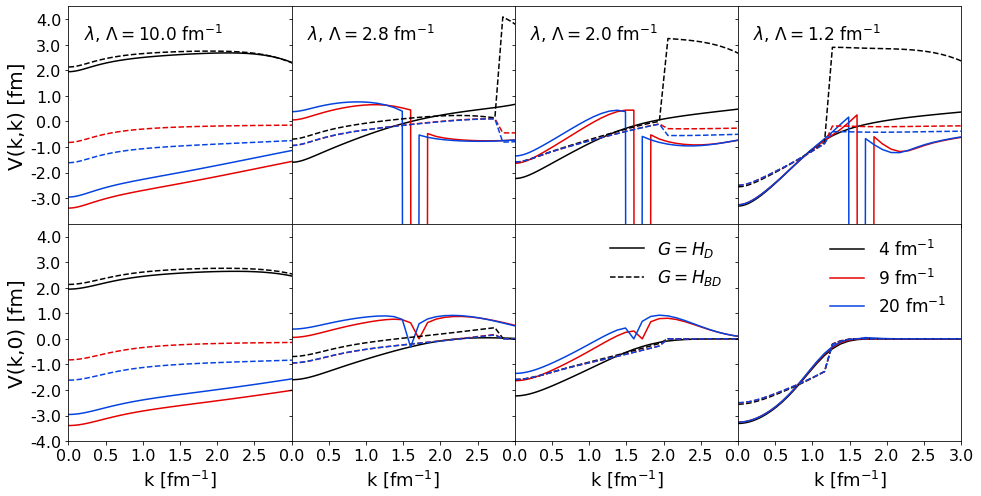

In [22]:
# Plot SRG-evolved potentials

# EM N3LO, RKE N4LO, Gezerlis N2LO for different channels and SRG generators
# 1S0 channel and Wegner generator
#potential_contours('1S0', 'Wegner', lambda_array_contours, em_n3lo, rke_n4lo, gez_n2lo)
# 3S1 channel and Wegner generator
#potential_contours('3S1', 'Wegner', lambda_array_contours, em_n3lo, rke_n4lo, gez_n2lo)
# 1P1 channel and Wegner generator
#potential_contours('1P1', 'Wegner', lambda_array_contours, em_n3lo, rke_n4lo, gez_n2lo)
# 3S1 channel and block-diagonal generator
#potential_contours('3S1', 'Block-diag', lambda_array_contours, em_n3lo, rke_n4lo, gez_n2lo)

# Band- and block-diagonal decoupling for different potentials and channels
# RKE N4LO (450 MeV) and 3S1 channel
#potential_contours_generators(111, '3S1', 8.0, 2.0, ntot, lambda_array_contours)
# RKE N4LO (450 MeV) and 1P1 channel
#potential_contours_generators(111, '1P1', 8.0, 2.0, ntot, lambda_array_contours)

# Band- and block-diagonal decoupling for different potentials and channels specifying slices of V(k, k')
# 1S0 channel
#potential_slices('1S0', lambda_array_slices, em_n3lo, rke_n4lo, gez_n2lo)
# 3S1 channel
#potential_slices('3S1', lambda_array_slices, em_n3lo, rke_n4lo, gez_n2lo)
# 1P1 channel
#potential_slices('1P1', lambda_array_slices, em_n3lo, rke_n4lo, gez_n2lo)
# 3S1 channel and high cutoff potentials
potential_slices_high_cutoffs(lambda_array_high_cutoffs)